In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
#Instantiate mediapipe face mesh and objects
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

mp_drawing = mp.solutions.drawing_utils

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

## Headpose detection with face mesh

In [3]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    success, image = cap.read()

    start = time.time()

    #Flip the image horizontally for a later selfie-view display, and convert color space from BGR to RGB.
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

    #To improve performance
    image.flags.writeable = False

    #Get the results from the face mesh model.
    results = face_mesh.process(image)

    #To improve performance
    image.flags.writeable = True

    #Convert color space back to BGR.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    img_h, img_w, img_c = image.shape
    face_3d = []
    face_2d = []

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx == 33 or idx == 263 or idx == 1 or idx ==61 or idx ==291 or idx ==199:
                    if idx == 1:
                        nose_2d = (lm.x * img_w, lm.y * img_h)
                        nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                    x, y = int(lm.x * img_w), int(lm.y * img_h)

                    #Get the 2d and 3d coordinates of the landmarks
                    face_2d.append([x, y])
                    face_3d.append([x, y, lm.z])

            #Convert it to a numpy array
            face_2d = np.array(face_2d, dtype=np.float64)
            face_3d = np.array(face_3d, dtype=np.float64)

            #The camera matrix
            focal_length = 1*img_w

            cam_matrix = np.array([[focal_length, 0, img_h / 2],
                                [0, focal_length, img_w / 2],
                                [0, 0, 1]])
            
            #The distortion parameters
            dist_matrix = np.zeros((4, 1), dtype=np.float64)

            #Solve Pnp
            success, rot_vector, trans_vector = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

            #Get rotational matrix
            rmat, jac = cv2.Rodrigues(rot_vector)

            #Get angles
            angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

            # Get the y rotation degree
            y = angles[0] * 360
            x = angles[1] * 360
            z = angles[2] * 360

            # See where the user's head is tilting
            if x < -10 and y > -8:
                text = "Looking Left"
            elif x > 10 and y > -8:
                text = "Looking Right"
            elif y < -8:
                text = "Looking Down"
            elif y > 25:
                text = "Looking Up"
            else:
                text = "Looking Center"

            # Display the nose direction
            nose_3d_projection, jacobian = cv2.projectPoints(nose_3d, rot_vector, trans_vector, cam_matrix, dist_matrix)

            p1 = (int(nose_2d[0]), int(nose_2d[1]))
            p2 = (int(nose_2d[0] + x * 10), int(nose_2d[1] - y * 10))

            cv2.line(image, p1, p2, (255, 0, 0), 3)

            #Add text on the image
            cv2.putText(image, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
            cv2.putText(image, "x: " + str(np.round(x, 2)), (500, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            cv2.putText(image, "y: " + str(np.round(y, 2)), (500, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            cv2.putText(image, "z: " + str(np.round(z, 2)), (500, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        
        end = time.time()
        totalTime = end - start

        fps = 1 / totalTime
        print("FPS: ", fps)
        
        cv2.putText(image, f'FPS: {int(fps)}', (20, 450), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)

        mp_drawing.draw_landmarks(
            image = image, 
            landmark_list = face_landmarks,
            connections = mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec = drawing_spec,
            connection_drawing_spec = drawing_spec)
        
    cv2.imshow('Head Pose Estimation', image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

FPS:  13.791971378965645
FPS:  70.41085128170693
FPS:  99.70532721610763
FPS:  91.12109493808386
FPS:  90.88219106844922
FPS:  11.869910232173785
FPS:  94.93886235541773
FPS:  83.31785224767088
FPS:  87.90878604963112
FPS:  99.82397600971035
FPS:  100.1505253104107
FPS:  90.96694716751973
FPS:  97.42187536292477
FPS:  99.97149326659516
FPS:  72.73317495274594
FPS:  95.24716141338905
FPS:  86.90876691324257
FPS:  83.34102966598446
FPS:  83.04894661808966
FPS:  87.19785451445915
FPS:  65.36136260927833
FPS:  58.850079274880386
FPS:  76.80328139019612
FPS:  100.13617915293894
FPS:  83.36587692796947
FPS:  83.35593624547876
FPS:  60.49680518094359
FPS:  83.3310949079133
FPS:  90.87825276796741
FPS:  73.95535493881582
FPS:  55.546338233346574
FPS:  62.48032176374199
FPS:  93.64166908530731
FPS:  90.90976873225394
FPS:  83.35096679318774
FPS:  100.00486397558475
FPS:  83.34102966598446
FPS:  99.93576364069574
FPS:  83.46375340775676
FPS:  83.31123249577912
FPS:  71.45200252125177
FPS:  94.68

## Capture with save pic implementation

In [5]:
# Video capture
cap = cv2.VideoCapture(0)

# Initialize the counter for captured images
image_counter = 0

while cap.isOpened():
    success, image = cap.read()

    start = time.time()

    # Flip the image horizontally for a later selfie-view display, and convert color space from BGR to RGB.
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

    # To improve performance
    image.flags.writeable = False

    # Get the results from the face mesh model.
    results = face_mesh.process(image)

    # To improve performance
    image.flags.writeable = True

    # Convert color space back to BGR.
    image_display = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_save = image.copy()  # Create a copy for saving without text

    img_h, img_w, img_c = image.shape
    face_3d = []
    face_2d = []

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                    if idx == 1:
                        nose_2d = (lm.x * img_w, lm.y * img_h)
                        nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                    x, y = int(lm.x * img_w), int(lm.y * img_h)

                    # Get the 2D and 3D coordinates of the landmarks
                    face_2d.append([x, y])
                    face_3d.append([x, y, lm.z])

            # Convert it to a numpy array
            face_2d = np.array(face_2d, dtype=np.float64)
            face_3d = np.array(face_3d, dtype=np.float64)

            # The camera matrix
            focal_length = 1 * img_w

            cam_matrix = np.array([[focal_length, 0, img_h / 2],
                                    [0, focal_length, img_w / 2],
                                    [0, 0, 1]])

            # The distortion parameters
            dist_matrix = np.zeros((4, 1), dtype=np.float64)

            # Solve PnP
            success, rot_vector, trans_vector = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

            # Get rotational matrix
            rmat, jac = cv2.Rodrigues(rot_vector)

            # Get angles
            angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

            # Get the y rotation degree
            y = angles[0] * 360
            x = angles[1] * 360
            z = angles[2] * 360

            # See where the user's head is tilting
            if x < -10 and y > -8:
                text = "Looking Left"
            elif x > 10 and y > -8:
                text = "Looking Right"
            elif y < -8:
                text = "Looking Down"
            elif y > 10:
                text = "Looking Up"
            else:
                text = "Looking Center"

            # Display the nose direction
            nose_3d_projection, jacobian = cv2.projectPoints(nose_3d, rot_vector, trans_vector, cam_matrix, dist_matrix)

            p1 = (int(nose_2d[0]), int(nose_2d[1]))
            p2 = (int(nose_2d[0] + x * 10), int(nose_2d[1] - y * 10))

            cv2.line(image_display, p1, p2, (255, 0, 0), 3)

        end = time.time()
        totalTime = end - start

        fps = 1 / totalTime
        print("FPS: ", fps)

        cv2.putText(image_display, f'FPS: {int(fps)}', (20, 450), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)

        # Display the text on the screen
        cv2.putText(image_display, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
        cv2.putText(image_display, "x: " + str(np.round(x, 2)), (500, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(image_display, "y: " + str(np.round(y, 2)), (500, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(image_display, "z: " + str(np.round(z, 2)), (500, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imshow('Head Pose Estimation', image_display)

    # Capture and save the image when 'c' key is pressed
    key = cv2.waitKey(1)
    if key == ord('c'):
        image_counter += 1
        filename = f'ResearchersImages/Folder 1/captured_image{image_counter}.jpg'
        cv2.imwrite(filename, image_save)
        print(f"Saved {filename}")

    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [40]:
def detect_head_direction(image):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    #Flip the image horizontally for a later selfie-view display, and convert color space from BGR to RGB.
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

    #To improve performance
    image.flags.writeable = False

    #Get the results from the face mesh model.
    results = face_mesh.process(image)

    #To improve performance
    image.flags.writeable = True

    #Convert color space back to BGR.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    img_h, img_w, img_c = image.shape
    face_3d = []
    face_2d = []

    if results.multi_face_landmarks:
        # Process only the first detected face
        face_landmarks = results.multi_face_landmarks[0]

        for idx, lm in enumerate(face_landmarks.landmark):
            if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                if idx == 1:
                    nose_2d = (lm.x * img_w, lm.y * img_h)
                    nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                x, y = int(lm.x * img_w), int(lm.y * img_h)

                # Get the 2d and 3d coordinates of the landmarks
                face_2d.append([x, y])
                face_3d.append([x, y, lm.z])

        # Convert it to a numpy array
        face_2d = np.array(face_2d, dtype=np.float64)
        face_3d = np.array(face_3d, dtype=np.float64)

        # The camera matrix
        focal_length = 1 * img_w

        cam_matrix = np.array([[focal_length, 0, img_h / 2],
                               [0, focal_length, img_w / 2],
                               [0, 0, 1]])

        # The distortion parameters
        dist_matrix = np.zeros((4, 1), dtype=np.float64)

        # Solve Pnp
        success, rot_vector, trans_vector = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

        # Get rotational matrix
        rmat, jac = cv2.Rodrigues(rot_vector)

        # Get angles
        angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

        # Get the y rotation degree
        y = angles[0] * 360
        x = angles[1] * 360
        z = angles[2] * 360

        # Determine head direction
        if x < -10 and y > -8:
            return ("Left", x, y, z)
        elif x > 10 and y > -8:
            return ("Right", x, y, z)
        elif y <= -8:
            return  ("Down", x, y, z)
        elif y > 25:
            return ("Up", x, y, z)
        else:
            return ("Center", x, y, z)

    else:
        x, y, z = "Nan", "Nan", "Nan"
        return ("No face detected", x, y, z)

In [41]:
#get the directory of testing data
testing_data_directory = "Headpose" 
#assign classes in array
classes = ["Center", "Down", "Left", "Right", "Up"]


In [42]:
validation_result = []
file_comp = []
def get_hp_accuracy():
    for category in classes:
        path = os.path.join(testing_data_directory, category)
        class_category = classes.index(category) # angry, sad, happy, etc..
        
        for img_file in os.listdir(path):
            try:
                img_path = os.path.join(path, img_file)
                img_array = cv2.imread(img_path)
                
                if img_array is not None:
                    direction = detect_head_direction(img_array)
                    print(img_path, ":", direction)
                    head_pose = direction[0]
                    x = direction[1]
                    y = direction[2]
                    z = direction[3]
                    validation_result.append([class_category, head_pose])
                    file_comp.append([img_file, head_pose, x, y, z])
                else:
                    print("Failed to load image:", img_file)
                    
            except Exception as e:
                print("Error processing image:", img_file, "Error:", str(e))


In [43]:
get_hp_accuracy()

Headpose\Center\Center1.jpg : ('Up', 6.007407304968455, 26.6501661367198, -0.14551664728407254)
Headpose\Center\Center10.jpg : ('Up', 3.8434480575792263, 27.510177056922476, -0.6164896186954785)
Headpose\Center\Center11.jpg : ('Center', 3.1376096857839464, 7.724104792115231, -0.2296233464055671)
Headpose\Center\Center12.jpg : ('Center', 5.580567004344244, 8.231172798762183, -0.00194390591643498)
Headpose\Center\Center13.jpg : ('Center', 3.6372775397050234, 8.147469935945114, -0.025431014957635518)
Headpose\Center\Center14.jpg : ('Center', 2.34071570935722, 17.513039465290074, -0.45061074615946106)
Headpose\Center\Center15.jpg : ('Center', 8.70782433282998, 13.39956344161206, -0.2841858149480511)
Headpose\Center\Center16.jpg : ('Center', 5.273535221375039, 12.524920662278255, -0.3085998856981928)
Headpose\Center\Center17.jpg : ('Center', 6.581658008894256, 11.517152374545207, -0.2715529418744932)
Headpose\Center\Center18.jpg : ('Center', 3.1720854435642565, 12.096819452727905, -0.239091

In [47]:
# Create a DataFrame from the validation results
df = pd.DataFrame(file_comp, columns=["Image Name", "Direction", "X", "Y", "Z"])

folder_name = "CSVs"
# Save the DataFrame to a CSV file
csv_filename = "headpose_for_visualization5.csv"
path = os.path.join(folder_name, csv_filename)

df.to_csv(path, index=False)

print("Validation results saved to ", path)

Validation results saved to  CSVs\headpose_for_visualization5.csv


In [44]:
def calculate_accuracy(data_list):
    correct_prediction = 0
    incorrect_prediction = 0
    
    for item in data_list:
        true_label = item[0]
        predicted_label = item[1]
        
        if (true_label == 0 and predicted_label == 'Center') or \
           (true_label == 1 and predicted_label == 'Down') or \
           (true_label == 2 and predicted_label == 'Left') or \
           (true_label == 3 and predicted_label == 'Right') or \
           (true_label == 4 and predicted_label == 'Up'):
            correct_prediction += 1
        else:
            incorrect_prediction += 1
    
    accuracy = correct_prediction / (correct_prediction + incorrect_prediction)
    print("The total number of data is " + str(len(data_list)))
    print("The number of correct predictions is: " + str(correct_prediction))
    print("The number of incorrect predictions is: " + str(incorrect_prediction))
    print("The accuracy of the model in the given dataset is: " + str(accuracy))

In [45]:
calculate_accuracy(validation_result)

The total number of data is 125
The number of correct predictions is: 115
The number of incorrect predictions is: 10
The accuracy of the model in the given dataset is: 0.92


In [ ]:
#Rename the images in the dataset
# Define the testing_data_directory and classes as you mentioned
testing_data_directory = "Headpose" 
classes = ["Center", "Down", "Left", "Right", "Up"]

# Function to rename images in a specific folder
def rename_images_in_folder(folder_path):
    if not os.path.exists(folder_path):
        return

    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    image_files.sort()  # Sort the image files alphabetically

    for i, image_file in enumerate(image_files, start=1):
        # Get the file extension (e.g., '.jpg')
        file_name, file_extension = os.path.splitext(image_file)
        
        # Construct the new file name
        new_file_name = f"{classes[folder_index]}{i}{file_extension}"

        # Rename the image file
        old_file_path = os.path.join(folder_path, image_file)
        new_file_path = os.path.join(folder_path, new_file_name)
        os.rename(old_file_path, new_file_path)
        print(f"Renamed: {old_file_path} -> {new_file_path}")

# Iterate through the classes and rename images in their respective folders
for folder_index, class_name in enumerate(classes):
    folder_path = os.path.join(testing_data_directory, class_name)
    rename_images_in_folder(folder_path)


In [3]:
df = pd.read_csv("CSVs/headpose_for_visualization4.csv")

In [13]:
df

,Image Name,Direction,X,Y,Z,Actual Class
0,Center1.jpg,Up,6.007407304968455,26.6501661367198,-0.14551664728407254,Center
1,Center10.jpg,Up,3.8434480575792263,27.510177056922476,-0.6164896186954785,Center
2,Center11.jpg,Center,3.1376096857839464,7.724104792115231,-0.2296233464055671,Center
3,Center12.jpg,Center,5.580567004344244,8.231172798762183,-0.00194390591643498,Center
4,Center13.jpg,Center,3.6372775397050234,8.147469935945114,-0.025431014957635518,Center
...,...,...,...,...,...,...
120,Up5.jpg,Up,-3.627618300161504,18.086126276869418,-0.05389476962259904,Up
121,Up6.jpg,Up,-4.497744716126691,40.0276572545441,0.13698745129072162,Up
122,Up7.jpg,Up,2.6235924436474707,36.62410020052649,0.2807820529463484,Up
123,Up8.jpg,Up,6.811340497773082,41.828495620114225,0.5800717530482711,Up


In [46]:
def visualize_correct_vs_incorrect_predictions(df):
    # Extract the direction part from the 'Image Name' and store it in the 'Actual Class' column
    df['Actual Class'] = df['Image Name'].str.extract(r'([A-Za-z]+)')
    # Calculate the counts of correct and incorrect predictions for each direction
    actual_classes = df['Actual Class'].unique()
    correct_counts = []
    incorrect_counts = []

    for actual_class in actual_classes:
        correct = ((df['Direction'] == actual_class) & (df['Actual Class'] == actual_class)).sum()
        incorrect = ((df['Direction'] != actual_class) & (df['Actual Class'] == actual_class)).sum()
        correct_counts.append(correct)
        incorrect_counts.append(incorrect)

    # Create the clustered bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(actual_classes))

    correct_bars = ax.bar(index, correct_counts, bar_width, label='Correct', color='green')
    incorrect_bars = ax.bar(index + bar_width, incorrect_counts, bar_width, label='Incorrect', color='red')

    ax.set_xlabel('Actual Class')
    ax.set_ylabel('Count')
    ax.set_title('Count of Correct and Incorrect Predictions by Actual Class')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(actual_classes)
    ax.legend()

    # Add predicted values for the incorrect predictions as text labels
    for i, actual_class in enumerate(actual_classes):
        incorrect_mask = (df['Direction'] != actual_class) & (df['Actual Class'] == actual_class)
        incorrect_predictions = df.loc[incorrect_mask, 'Direction'].value_counts()
        for j, value in enumerate(incorrect_predictions.index):
            ax.text(i + bar_width + 0.05, incorrect_counts[i] - j * 1, f'{value}: {incorrect_predictions[value]}', color='black')

    plt.tight_layout()
    plt.show()

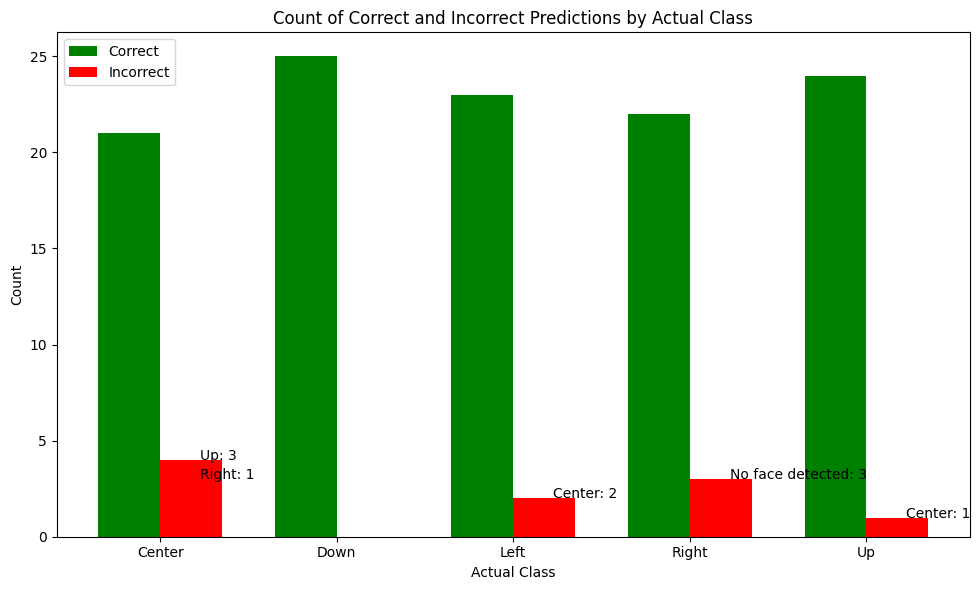

In [48]:
visualize_correct_vs_incorrect_predictions(df)

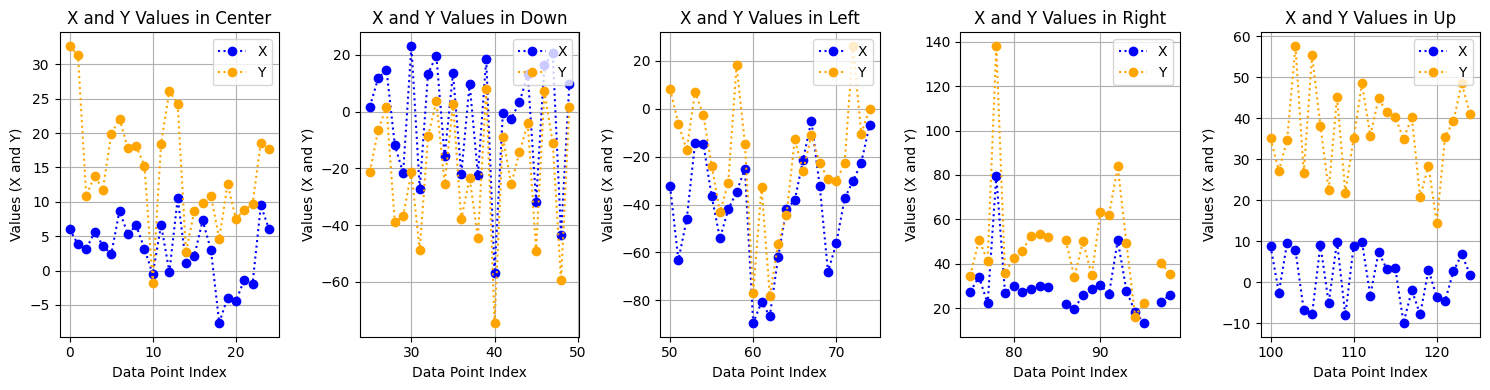

In [37]:
# Define the classes
classes = ['Center', 'Down', 'Left', 'Right', 'Up']

# Create a figure and axis for subplots in a single row
fig, axs = plt.subplots(1, len(classes), figsize=(15, 4))  # Adjust the figsize as needed

# Iterate over the classes and plot dotted line charts for each class
for i, class_label in enumerate(classes):
    filtered_df = df[df['Actual Class'] == class_label]
    
    # Sort the DataFrame by index to ensure the Y-axis values are ordered
    filtered_df = filtered_df.sort_index()
    
    # Round the 'X' and 'Y' values to two decimal places
    filtered_df['X'] = filtered_df['X'].round(2)
    filtered_df['Y'] = filtered_df['Y'].round(2)
    
    # Create dotted line charts for 'X' and 'Y' values within each class
    axs[i].plot(filtered_df.index, filtered_df['X'], label='X', linestyle='dotted', color='blue', marker='o')
    axs[i].plot(filtered_df.index, filtered_df['X'] + filtered_df['Y'], label='Y', linestyle='dotted', color='orange', marker='o')
    
    axs[i].set_xlabel('Data Point Index')
    axs[i].set_ylabel('Values (X and Y)')
    axs[i].set_title(f'X and Y Values in {class_label}')
    
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

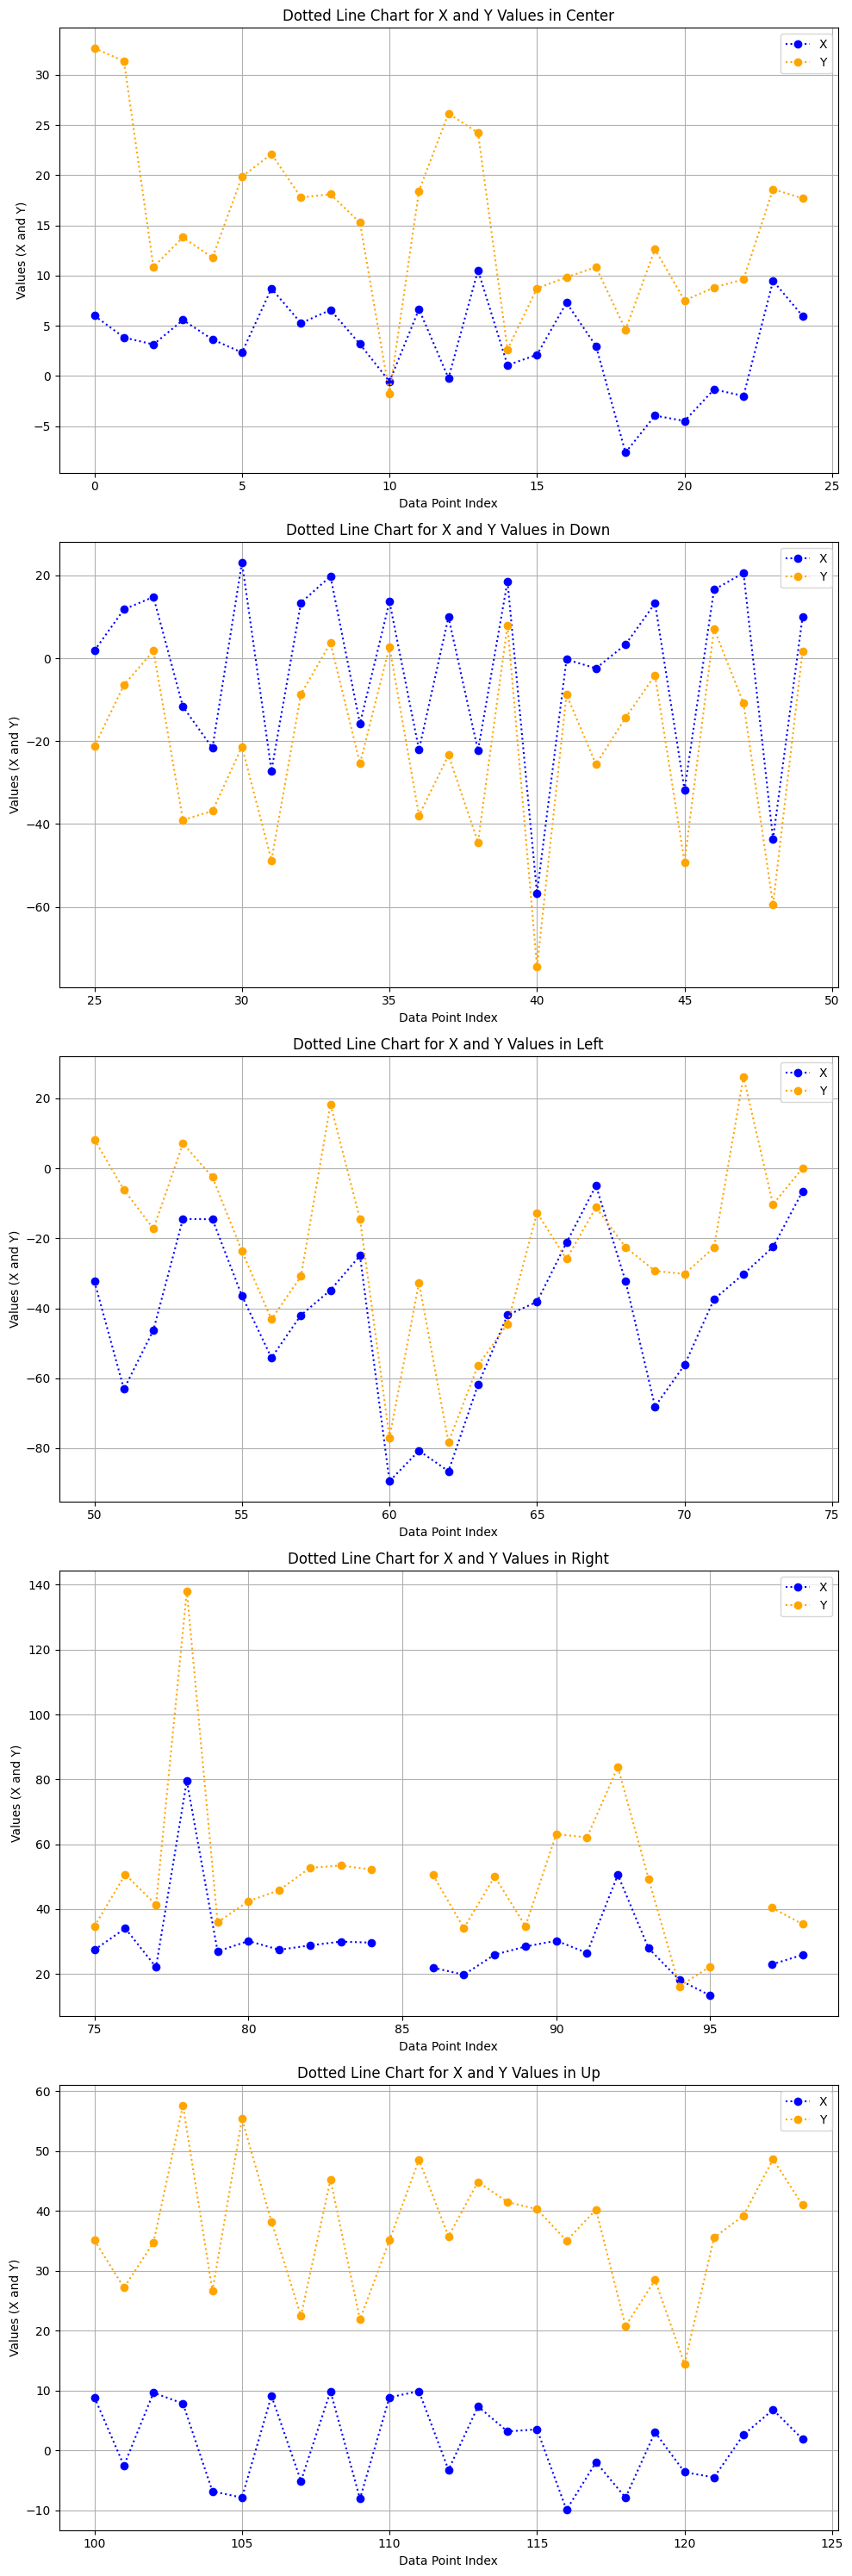

In [36]:
# Define the classes
classes = ['Center', 'Down', 'Left', 'Right', 'Up']

# Create a figure and axis for subplots
fig, axs = plt.subplots(len(classes), 1, figsize=(10, 6 * len(classes)))

# Iterate over the classes and plot dotted line charts for each class
for i, class_label in enumerate(classes):
    filtered_df = df[df['Actual Class'] == class_label]
    
    # Sort the DataFrame by index to ensure the Y-axis values are ordered
    filtered_df = filtered_df.sort_index()
    
    # Round the 'X' and 'Y' values to two decimal places
    filtered_df['X'] = filtered_df['X'].round(2)
    filtered_df['Y'] = filtered_df['Y'].round(2)
    
    # Create dotted line charts for 'X' and 'Y' values within each class
    axs[i].plot(filtered_df.index, filtered_df['X'], label='X', linestyle='dotted', color='blue', marker='o')
    axs[i].plot(filtered_df.index, filtered_df['X'] + filtered_df['Y'], label='Y', linestyle='dotted', color='orange', marker='o')
    
    axs[i].set_xlabel('Data Point Index')
    axs[i].set_ylabel('Values (X and Y)')
    axs[i].set_title(f'Dotted Line Chart for X and Y Values in {class_label}')
    
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [11]:
def visualize_mean_median_values(df):
    # Extract the direction part from the 'Image Name' and store it in the 'Actual Class' column
    df['Actual Class'] = df['Image Name'].str.extract(r'([A-Za-z]+)')

    # Convert 'X' and 'Y' columns to numeric (replace non-numeric values with NaN)
    df['X'] = pd.to_numeric(df['X'], errors='coerce')
    df['Y'] = pd.to_numeric(df['Y'], errors='coerce')

    # Drop rows with 'NaN' values in 'X' and 'Y' columns
    df.dropna(subset=['X', 'Y'], how='any', inplace=True)

    # Group the DataFrame by 'Actual Class' and calculate mean and median for 'X' and 'Y'
    grouped = df.groupby('Actual Class').agg({'X': ['mean', 'median'], 'Y': ['mean', 'median']}).reset_index()

    # Create the clustered bar graph
    fig, ax = plt.subplots(figsize=(9, 6))
    bar_width = 0.35
    index = range(len(grouped))

    bar1 = ax.bar(index, grouped[('X', 'mean')], bar_width, label='X Mean', color='orange')
    bar2 = ax.bar(index, grouped[('X', 'median')], bar_width, label='X Median', color='lightcoral', alpha=0.7, align='edge')
    bar3 = ax.bar(index, grouped[('Y', 'mean')], bar_width, label='Y Mean', color='blue', align='edge')
    bar4 = ax.bar(index, grouped[('Y', 'median')], bar_width, label='Y Median', color='deepskyblue', alpha=0.7, align='edge')

    ax.set_xlabel('Actual Class')
    ax.set_ylabel('Values')
    ax.set_title('Mean and Median Values of X and Y Grouped by Actual Class')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(grouped['Actual Class'])
    ax.legend()

    plt.tight_layout()
    plt.show()


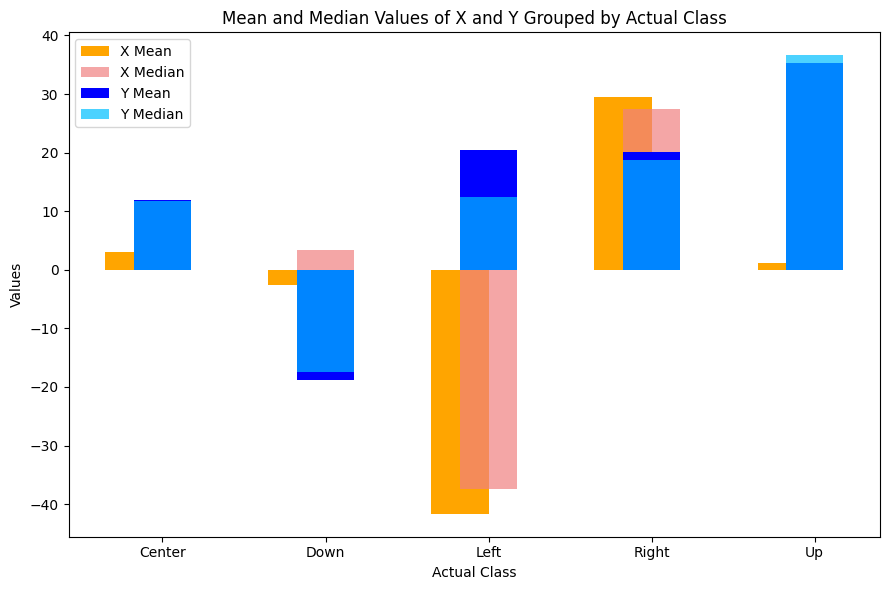

In [12]:
visualize_mean_median_values(df)

In [13]:
# Calculate mean and median of 'X' and 'Y' for each class
result = df.groupby('Actual Class').agg({'X': ['mean', 'median'], 'Y': ['mean', 'median']}).reset_index()

# Print the result
print(result)

  Actual Class          X                     Y           
                     mean     median       mean     median
0       Center   2.971261   3.172085  11.916482  11.699390
1         Down  -2.602253   3.299279 -18.809063 -17.442817
2         Left -41.656462 -37.432385  20.369033  12.381148
3        Right  29.443958  27.437198  20.068443  18.801428
4           Up   1.237593   2.623592  35.317262  36.624100
